In [54]:
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import torch
import random
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import EEGModels 
from EEG_transformer_code.method_A.model import EEGT
import EEG_transformer_code.method_A.params_full_c as params
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
warnings.filterwarnings('ignore')

Num GPUs Available:  3


# Configurations

In [55]:
data_path = './dataset'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
cross = 20

cuda:1


# SVM

In [56]:

def plot_confusion_matrix(y_true_list, y_pred_list, target_names, save_name, preload_cm=None, cmap=plt.cm.Blues, normalize=True, ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams.update({'font.family':'Times New Roman'})
    plt.rcParams["font.size"] = 18
    # Compute confusion matrix
    if preload_cm is None:
        cm = []
        for y_true, y_pred in zip(y_true_list, y_pred_list):
            cm.append(confusion_matrix(y_true, y_pred,labels=range(len(target_names))))
        cm = np.mean(cm, axis=0)
        # Only use the labels that appear in the data
    else:
        cm = preload_cm

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=target_names, yticklabels=target_names)
    ax.set_yticklabels(target_names, rotation='vertical', va='center')
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j]*100, fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if 'pdf' not in save_name:
        fig.savefig(save_name, dpi=200)
    else:
        fig.savefig(save_name, format="pdf", bbox_inches="tight")
    plt.clf()
    return

In [57]:
data_list = os.listdir(data_path)
acc_tests_SVM = []
f1_tests_SVM = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label, test_data, test_label = traindata[:,:-1], traindata[:,-1], testdata[:,:-1], testdata[:,-1]
        classifier = svm.SVC(C=1,kernel='rbf')
        classifier.fit(train_data, train_label)
        tests.append(classifier.score(test_data, test_label))
        tests_f1.append(f1_score(test_label, classifier.predict(test_data)))
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_SVM.append(acc_test*100)
    f1_tests_SVM.append(f1_test*100)

Begin to process person huangsiye_20210529_1.
Acc of test set: 0.97892
F1 of test set: 0.98934
Begin to process person huangsiye_20210531_2.
Acc of test set: 0.97999
F1 of test set: 0.98988
Begin to process person huangsiye_20210604_3.
Acc of test set: 0.95459
F1 of test set: 0.97666
Begin to process person liangjie_20210424_2.
Acc of test set: 0.84233
F1 of test set: 0.91387
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 0.85585
F1 of test set: 0.92140
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 0.88032
F1 of test set: 0.93596
Begin to process person tana_20210425_1.
Acc of test set: 0.98216
F1 of test set: 0.99096
Begin to process person zengcheng_20210615_1.
Acc of test set: 0.85148
F1 of test set: 0.91944
Begin to process person zengjingyao_20210604_2.
Acc of test set: 0.94068
F1 of test set: 0.96873
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 0.89163
F1 of test set: 0.94242
Begin to process person zhengwenxin_20210429_2.
Acc 

# Logistic Regression

In [58]:
data_list = os.listdir(data_path)
acc_tests_LR = []
f1_tests_LR = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label, test_data, test_label = traindata[:,:-1], traindata[:,-1], testdata[:,:-1], testdata[:,-1]
        classifier = LogisticRegression(penalty="l1", C=0.5, solver="liblinear")
        classifier.fit(train_data, train_label)
        tests.append(classifier.score(test_data, test_label))
        tests_f1.append(f1_score(test_label, classifier.predict(test_data)))
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_LR.append(acc_test*100)
    f1_tests_LR.append(f1_test*100)

Begin to process person huangsiye_20210529_1.
Acc of test set: 0.98101
F1 of test set: 0.99038
Begin to process person huangsiye_20210531_2.
Acc of test set: 0.97798
F1 of test set: 0.98886
Begin to process person huangsiye_20210604_3.
Acc of test set: 0.95484
F1 of test set: 0.97679
Begin to process person liangjie_20210424_2.
Acc of test set: 0.82818
F1 of test set: 0.89937
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 0.82826
F1 of test set: 0.90355
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 0.85646
F1 of test set: 0.92044
Begin to process person tana_20210425_1.
Acc of test set: 0.97840
F1 of test set: 0.98905
Begin to process person zengcheng_20210615_1.
Acc of test set: 0.84224
F1 of test set: 0.90901
Begin to process person zengjingyao_20210604_2.
Acc of test set: 0.92837
F1 of test set: 0.96208
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 0.87008
F1 of test set: 0.92893
Begin to process person zhengwenxin_20210429_2.
Acc 

# Decision Tree

In [59]:
data_list = os.listdir(data_path)
acc_tests_DTC = []
f1_tests_DTC = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label, test_data, test_label = traindata[:,:-1], traindata[:,-1], testdata[:,:-1], testdata[:,-1]
        classifier = DecisionTreeClassifier(criterion = 'entropy')
        classifier.fit(train_data, train_label)
        tests.append(classifier.score(test_data, test_label))
        tests_f1.append(f1_score(test_label, classifier.predict(test_data)))
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_DTC.append(acc_test*100)
    f1_tests_DTC.append(f1_test*100)

Begin to process person huangsiye_20210529_1.
Acc of test set: 0.96931
F1 of test set: 0.98432
Begin to process person huangsiye_20210531_2.
Acc of test set: 0.96116
F1 of test set: 0.98013
Begin to process person huangsiye_20210604_3.
Acc of test set: 0.92535
F1 of test set: 0.96106
Begin to process person liangjie_20210424_2.
Acc of test set: 0.76296
F1 of test set: 0.85757
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 0.79678
F1 of test set: 0.88312
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 0.81020
F1 of test set: 0.89067
Begin to process person tana_20210425_1.
Acc of test set: 0.95950
F1 of test set: 0.97907
Begin to process person zengcheng_20210615_1.
Acc of test set: 0.80855
F1 of test set: 0.88891
Begin to process person zengjingyao_20210604_2.
Acc of test set: 0.91015
F1 of test set: 0.95176
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 0.81995
F1 of test set: 0.89793
Begin to process person zhengwenxin_20210429_2.
Acc 

# Multi-layer Perceptron

In [60]:
class MLP(nn.Module):
    def __init__(self, num_classes=2):
        super(MLP, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(310, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [61]:
def Validation(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            f1 = f1_score(labels.cpu().numpy(), predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total * 100, f1 * 100

In [62]:
data_list = os.listdir(data_path)
acc_tests_MLP = []
f1_tests_MLP = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = torch.from_numpy(traindata[:,:-1]).float(), torch.from_numpy(traindata[:,-1])
        test_data, test_label = torch.from_numpy(testdata[:,:-1]).float(), torch.from_numpy(testdata[:,-1])
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = MLP().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 15
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print("Train Epoch: {} of {} [{} of {}] Loss: {:.5f}".format(epoch+1, epoches, i+1, len(train_loader), loss.item()))
        acc, f1 = Validation(net=net, testloader=test_loader)
        tests.append(acc)
        tests_f1.append(f1)
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_MLP.append(acc_test)
    f1_tests_MLP.append(f1_test)

Begin to process person huangsiye_20210529_1.
Acc of test set: 97.70390
F1 of test set: 98.63278
Begin to process person huangsiye_20210531_2.
Acc of test set: 98.27070
F1 of test set: 99.38471
Begin to process person huangsiye_20210604_3.
Acc of test set: 95.45654
F1 of test set: 98.96012
Begin to process person liangjie_20210424_2.
Acc of test set: 85.11806
F1 of test set: 89.94794
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 84.62328
F1 of test set: 89.93473
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 87.27526
F1 of test set: 85.27194
Begin to process person tana_20210425_1.
Acc of test set: 97.91745
F1 of test set: 99.17639
Begin to process person zengcheng_20210615_1.
Acc of test set: 85.65470
F1 of test set: 91.14177
Begin to process person zengjingyao_20210604_2.
Acc of test set: 90.90428
F1 of test set: 90.26284
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 88.11891
F1 of test set: 90.94266
Begin to process person zhengwen

# Convolution Neural Network

In [63]:
class CNN(nn.Module):
    def __init__(self, num_classes = 2):
        super(CNN, self).__init__()
        # self.feature_extraction = nn.Sequential(
        #     nn.Conv1d(in_channels = 1, out_channels = 2, kernel_size = 16, padding = 1),
        #     nn.MaxPool1d(kernel_size = 8, stride = 1),
        #     nn.ReLU(),
        #     nn.Conv1d(in_channels = 2, out_channels = 2, kernel_size = 16),
        #     nn.Conv1d(in_channels = 2, out_channels = 4, kernel_size = 16, padding = 1),
        #     nn.ReLU()
        # )  
        # self.classifier = nn.Sequential(
        #     nn.Linear(1048, 2048),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(2048, num_classes)
        # )
        self.feature_extraction = nn.Sequential(
            nn.Conv1d(in_channels = 5, out_channels = 8, kernel_size = 4, padding = 1),
            nn.MaxPool1d(kernel_size = 4, stride = 1),
            nn.ReLU(),
            nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = 4),
            nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = 4, padding = 1),
            nn.ReLU()
        )  
        self.classifier = nn.Sequential(
            nn.Linear(1728, 2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, num_classes)
        )
    
    def forward(self, x):
        x = self.feature_extraction(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [64]:
data_list = os.listdir(data_path)
acc_tests_CNN = []
f1_tests_CNN = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = torch.from_numpy(traindata[:,:-1]).float(), torch.from_numpy(traindata[:,-1])
        test_data, test_label = torch.from_numpy(testdata[:,:-1]).float(), torch.from_numpy(testdata[:,-1])
        train_data = train_data.reshape(train_data.shape[0], 62, 5).permute(0, 2, 1)
        test_data = test_data.reshape(test_data.shape[0], 62, 5).permute(0, 2, 1)
        # train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1).permute(0, 2, 1)
        # test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1).permute(0, 2, 1)
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = CNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 15
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print("Train Epoch: {} of {} [{} of {}] Loss: {:.5f}".format(epoch+1, epoches, i+1, len(train_loader), loss.item()))
        acc, f1 = Validation(net=net, testloader=test_loader)
        tests.append(acc)
        tests_f1.append(f1)
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_CNN.append(acc_test)
    f1_tests_CNN.append(f1_test)

Begin to process person huangsiye_20210529_1.
Acc of test set: 97.72335
F1 of test set: 98.86154
Begin to process person huangsiye_20210531_2.
Acc of test set: 98.30858
F1 of test set: 99.44960
Begin to process person huangsiye_20210604_3.
Acc of test set: 96.19003
F1 of test set: 99.16583
Begin to process person liangjie_20210424_2.
Acc of test set: 84.88921
F1 of test set: 85.78005
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 84.89951
F1 of test set: 92.61538
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 89.70208
F1 of test set: 93.67101
Begin to process person tana_20210425_1.
Acc of test set: 98.21125
F1 of test set: 98.95348
Begin to process person zengcheng_20210615_1.
Acc of test set: 86.62218
F1 of test set: 81.14738
Begin to process person zengjingyao_20210604_2.
Acc of test set: 93.71510
F1 of test set: 97.57426
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 88.62145
F1 of test set: 87.45036
Begin to process person zhengwen

# Recurrent Neural Network

In [65]:
class RNN(nn.Module):
    def __init__(self, hidden_size = 32, num_classes = 2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size = 5, hidden_size = self.hidden_size, num_layers = 2, batch_first = True, bidirectional = True)
        self.classifier = nn.Sequential(
            nn.Linear(62 * self.hidden_size * 2, 2048),
            nn.ReLU(),
            nn.Linear(2048, num_classes)
        )
    
    def forward(self, x):
        x, _ = self.rnn(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [66]:
data_list = os.listdir(data_path)
acc_tests_RNN = []
f1_tests_RNN = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = torch.from_numpy(traindata[:,:-1]).float(), torch.from_numpy(traindata[:,-1])
        test_data, test_label = torch.from_numpy(testdata[:,:-1]).float(), torch.from_numpy(testdata[:,-1])
        train_data = train_data.reshape(train_data.shape[0], 62, 5)
        test_data = test_data.reshape(test_data.shape[0], 62, 5)
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = RNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 15
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print("Train Epoch: {} of {} [{} of {}] Loss: {:.5f}".format(epoch+1, epoches, i+1, len(train_loader), loss.item()))
        acc, f1 = Validation(net=net, testloader=test_loader)
        tests.append(acc)
        tests_f1.append(f1)
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_RNN.append(acc_test)
    f1_tests_RNN.append(f1_test)

Begin to process person huangsiye_20210529_1.
Acc of test set: 97.64606
F1 of test set: 98.68811
Begin to process person huangsiye_20210531_2.
Acc of test set: 98.19729
F1 of test set: 99.48537
Begin to process person huangsiye_20210604_3.
Acc of test set: 95.78741
F1 of test set: 97.63637
Begin to process person liangjie_20210424_2.
Acc of test set: 82.28766
F1 of test set: 88.33575
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 86.30601
F1 of test set: 95.22830
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 90.16378
F1 of test set: 91.25037
Begin to process person tana_20210425_1.
Acc of test set: 98.54997
F1 of test set: 99.36074
Begin to process person zengcheng_20210615_1.
Acc of test set: 85.00193
F1 of test set: 90.69742
Begin to process person zengjingyao_20210604_2.
Acc of test set: 91.40297
F1 of test set: 92.10669
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 88.93118
F1 of test set: 92.30306
Begin to process person zhengwen

# EEGNet

In [67]:
data_list = os.listdir(data_path)
acc_tests_EEGNet = []
f1_tests_EEGNet = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = tf.convert_to_tensor(traindata[:,:-1]), tf.convert_to_tensor(traindata[:,-1])
        test_data, test_label = tf.convert_to_tensor(testdata[:,:-1]), tf.convert_to_tensor(testdata[:,-1])
        train_data = tf.reshape(train_data, [train_data.shape[0], 62, 5])
        test_data = tf.reshape(test_data, [test_data.shape[0], 62, 5])
        net = EEGModels.EEGNet_SSVEP(nb_classes=2, Chans=62, Samples=5)
        net.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = 'adam')
        net.fit(train_data,train_label,batch_size=64,epochs = 15)
        y = net(test_data).numpy()
        y = torch.Tensor(y)
        _, predicted = torch.max(y, 1)
        predicted = predicted.numpy()
        tests.append((predicted==test_label.numpy()).sum().item()/test_label.shape[0])
        tests_f1.append(f1_score(test_label, predicted))
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    acc_tests_EEGNet.append(acc_test*100)
    f1_tests_EEGNet.append(f1_test*100)
print("Acc of test set: {}".format(acc_tests_EEGNet))
print("F1 of test set: {}".format(f1_tests_EEGNet))

7/7 [==============================] - 0s 7ms/step - loss: 0.3758
Epoch 13/15
7/7 [==============================] - 0s 7ms/step - loss: 0.3833
Epoch 14/15
7/7 [==============================] - 0s 7ms/step - loss: 0.3641
Epoch 15/15
7/7 [==============================] - 0s 8ms/step - loss: 0.3671
Epoch 1/15
8/8 [==============================] - 1s 7ms/step - loss: 0.7394
Epoch 2/15
8/8 [==============================] - 0s 7ms/step - loss: 0.6466
Epoch 3/15
8/8 [==============================] - 0s 8ms/step - loss: 0.5908
Epoch 4/15
8/8 [==============================] - 0s 7ms/step - loss: 0.5561
Epoch 5/15
8/8 [==============================] - 0s 8ms/step - loss: 0.5191
Epoch 6/15
8/8 [==============================] - 0s 8ms/step - loss: 0.4851
Epoch 7/15
8/8 [==============================] - 0s 7ms/step - loss: 0.4547
Epoch 8/15
8/8 [==============================] - 0s 7ms/step - loss: 0.4209
Epoch 9/15
8/8 [==============================] - 0s 7ms/step - loss: 0.3969
Epoch 1

2023-12-14 07:55:29.984326: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_648/dropout_1296/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


7/7 [==============================] - 1s 8ms/step - loss: 0.7356
Epoch 2/15
7/7 [==============================] - 0s 7ms/step - loss: 0.6906
Epoch 3/15
7/7 [==============================] - 0s 8ms/step - loss: 0.6200
Epoch 4/15
7/7 [==============================] - 0s 7ms/step - loss: 0.5805
Epoch 5/15
7/7 [==============================] - 0s 7ms/step - loss: 0.5387
Epoch 6/15
7/7 [==============================] - 0s 7ms/step - loss: 0.5085
Epoch 7/15
7/7 [==============================] - 0s 7ms/step - loss: 0.4799
Epoch 8/15
7/7 [==============================] - 0s 7ms/step - loss: 0.4557
Epoch 9/15
7/7 [==============================] - 0s 7ms/step - loss: 0.4502
Epoch 10/15
7/7 [==============================] - 0s 7ms/step - loss: 0.4185
Epoch 11/15
7/7 [==============================] - 0s 8ms/step - loss: 0.3949
Epoch 12/15
7/7 [==============================] - 0s 8ms/step - loss: 0.3853
Epoch 13/15
7/7 [==============================] - 0s 8ms/step - loss: 0.3828
Epoch 

2023-12-14 07:56:30.679409: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_674/dropout_1348/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6/6 [==============================] - 1s 8ms/step - loss: 0.7978
Epoch 2/15
6/6 [==============================] - 0s 7ms/step - loss: 0.6846
Epoch 3/15
6/6 [==============================] - 0s 8ms/step - loss: 0.6594
Epoch 4/15
6/6 [==============================] - 0s 8ms/step - loss: 0.6074
Epoch 5/15
6/6 [==============================] - 0s 8ms/step - loss: 0.5848
Epoch 6/15
6/6 [==============================] - 0s 7ms/step - loss: 0.5645
Epoch 7/15
6/6 [==============================] - 0s 7ms/step - loss: 0.5293
Epoch 8/15
6/6 [==============================] - 0s 8ms/step - loss: 0.5090
Epoch 9/15
6/6 [==============================] - 0s 7ms/step - loss: 0.5092
Epoch 10/15
6/6 [==============================] - 0s 7ms/step - loss: 0.4828
Epoch 11/15
6/6 [==============================] - 0s 8ms/step - loss: 0.4754
Epoch 12/15
6/6 [==============================] - 0s 8ms/step - loss: 0.4616
Epoch 13/15
6/6 [==============================] - 0s 8ms/step - loss: 0.4538
Epoch 

In [68]:
def define_model(i):
    return EEGT(
        params.ENC_INPUT_LEN,
        params.CLASSES,
        params.ENC_INPUT_DIM,
        params.ENC_DEPTH[i],
        params.ENC_HEADS,
        params.ENC_MLP_DIM[i],
        params.ENC_POOL,
        params.ENC_DIM_HEAD[i],
        params.ENC_DROPOUT,
        params.ENC_EMB_DROPOUT,
    )

In [69]:
data_list = os.listdir(data_path)
acc_tests_Transformer = []
f1_tests_Transformer = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = torch.from_numpy(traindata[:,:-1]).float(), torch.from_numpy(traindata[:,-1])
        test_data, test_label = torch.from_numpy(testdata[:,:-1]).float(), torch.from_numpy(testdata[:,-1])
        train_data = train_data.reshape(train_data.shape[0], 62, 5)
        test_data = test_data.reshape(test_data.shape[0], 62, 5)
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = define_model(0).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 15
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                net.train()
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print("Train Epoch: {} of {} [{} of {}] Loss: {:.5f}".format(epoch+1, epoches, i+1, len(train_loader), loss.item()))
        acc, f1 = Validation(net=net, testloader=test_loader)
        tests.append(acc)
        tests_f1.append(f1)
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_Transformer.append(acc_test)
    f1_tests_Transformer.append(f1_test)

Begin to process person huangsiye_20210529_1.
Acc of test set: 97.79259
F1 of test set: 98.87196
Begin to process person huangsiye_20210531_2.
Acc of test set: 98.25671
F1 of test set: 99.23060
Begin to process person huangsiye_20210604_3.
Acc of test set: 96.10633
F1 of test set: 98.51287
Begin to process person liangjie_20210424_2.
Acc of test set: 83.78658
F1 of test set: 86.96264
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 88.47233
F1 of test set: 89.92255
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 88.66893
F1 of test set: 90.05917
Begin to process person tana_20210425_1.
Acc of test set: 98.09256
F1 of test set: 99.71974
Begin to process person zengcheng_20210615_1.
Acc of test set: 86.18355
F1 of test set: 81.24890
Begin to process person zengjingyao_20210604_2.
Acc of test set: 94.75192
F1 of test set: 96.36976
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 89.51268
F1 of test set: 93.59765
Begin to process person zhengwen

# Comparison of different models

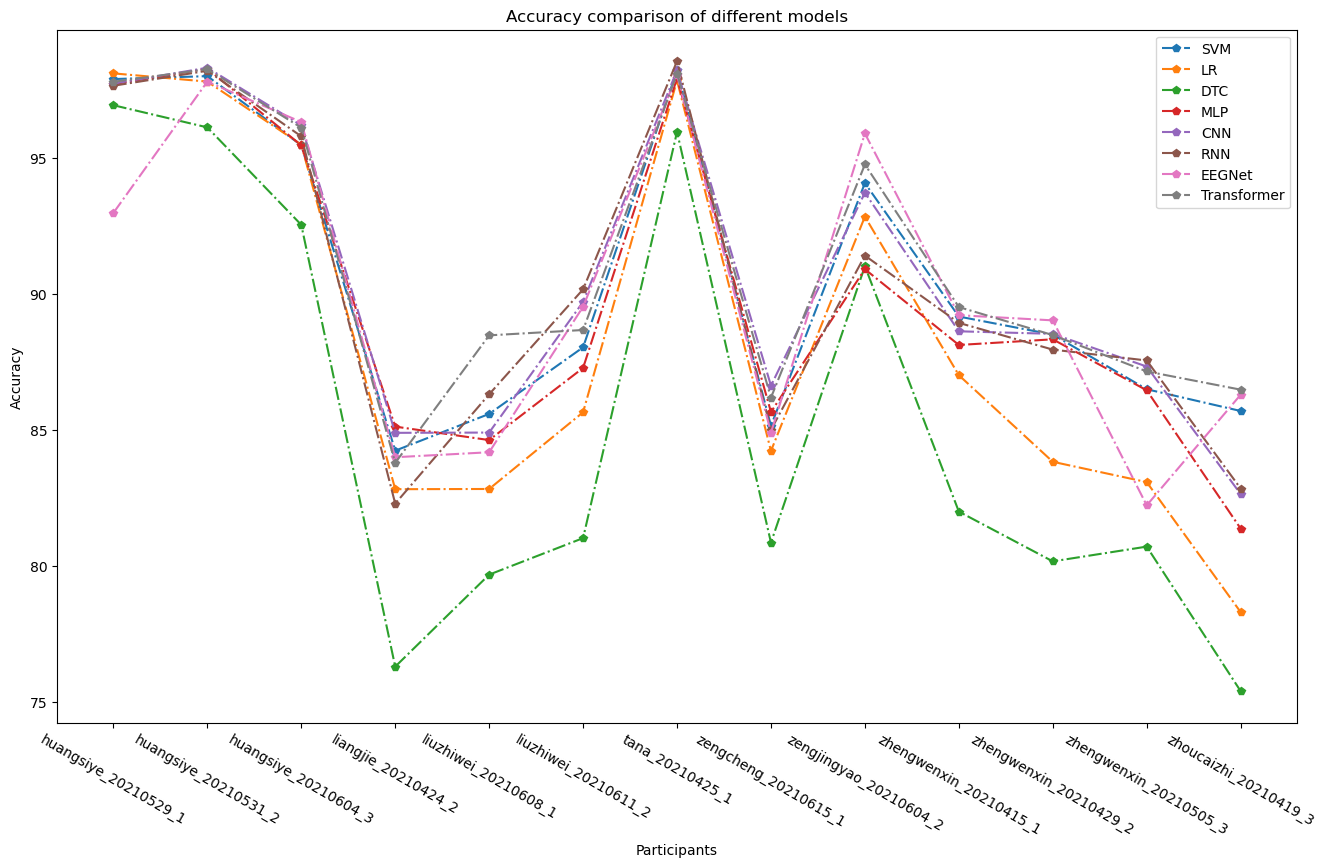

In [70]:
plt.figure(figsize = (16, 9))
plt.xlabel('Participants')
plt.xticks(rotation = -30)
plt.ylabel('Accuracy')
plt.title("Accuracy comparison of different models")
x = os.listdir(data_path)
plt.plot(x, acc_tests_SVM, '-.p')
plt.plot(x, acc_tests_LR, '-.p')
plt.plot(x, acc_tests_DTC, '-.p')
plt.plot(x, acc_tests_MLP, '-.p')
plt.plot(x, acc_tests_CNN, '-.p')
plt.plot(x, acc_tests_RNN, '-.p')
plt.plot(x, acc_tests_EEGNet, '-.p')
plt.plot(x, acc_tests_Transformer, '-.p')
plt.legend(['SVM','LR','DTC','MLP','CNN','RNN','EEGNet','Transformer'])
plt.show()

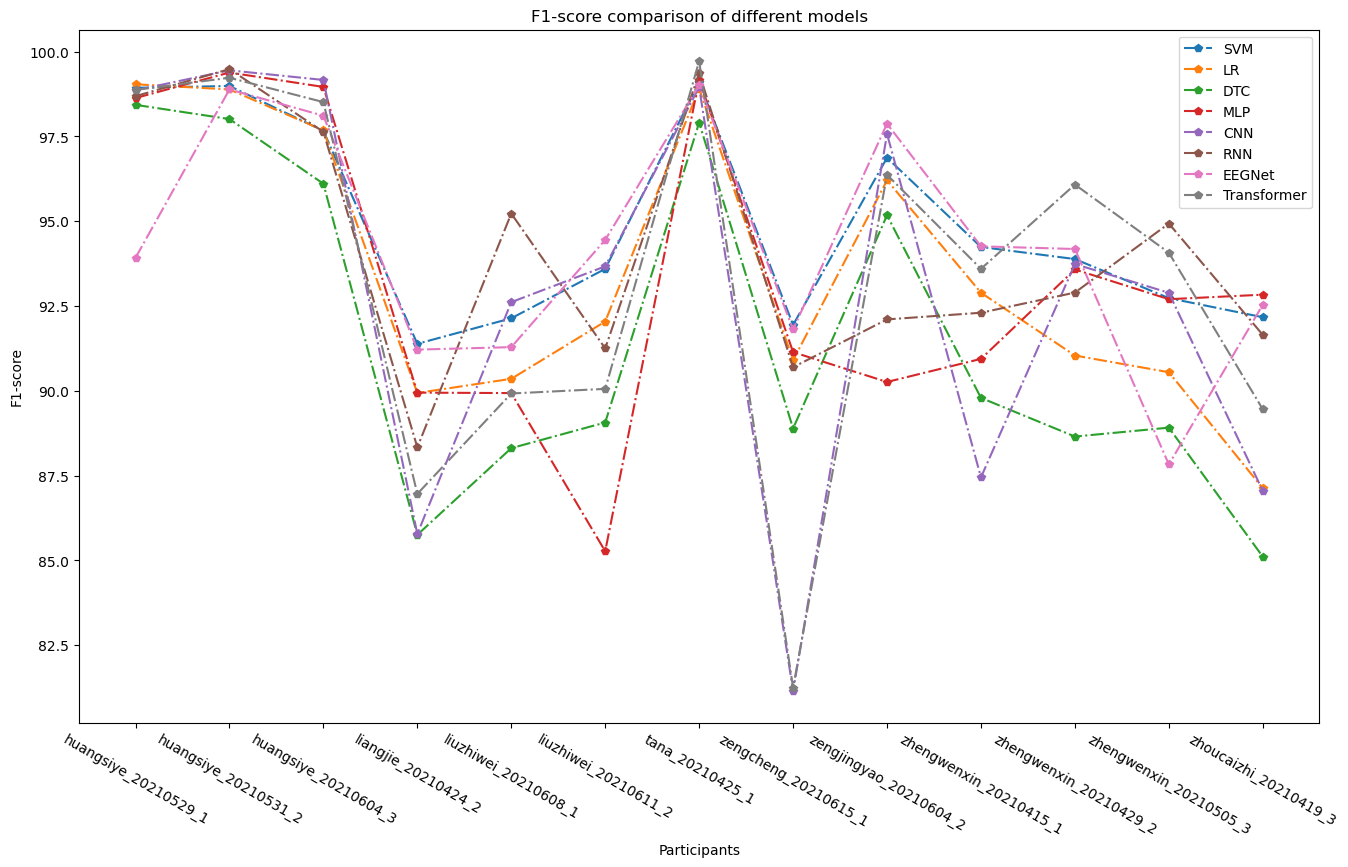

In [71]:
plt.figure(figsize = (16, 9))
plt.xlabel('Participants')
plt.xticks(rotation = -30)
plt.ylabel('F1-score')
plt.title("F1-score comparison of different models")
x = os.listdir(data_path)
plt.plot(x, f1_tests_SVM, '-.p')
plt.plot(x, f1_tests_LR, '-.p')
plt.plot(x, f1_tests_DTC, '-.p')
plt.plot(x, f1_tests_MLP, '-.p')
plt.plot(x, f1_tests_CNN, '-.p')
plt.plot(x, f1_tests_RNN, '-.p')
plt.plot(x, f1_tests_EEGNet, '-.p')
plt.plot(x, f1_tests_Transformer, '-.p')
plt.legend(['SVM','LR','DTC','MLP','CNN','RNN','EEGNet','Transformer'])
plt.show()

[90.49853399069406, 88.44504815528596, 85.2813321065649, 89.78398857347018, 90.56732186799029, 90.20113240836594, 90.02768325114707, 91.05607292856871]
[5.19519657496249, 6.690168626875999, 7.635688979811913, 5.497419919229369, 5.357083122315756, 5.508107113641728, 5.413181319723576, 4.962426966035907]


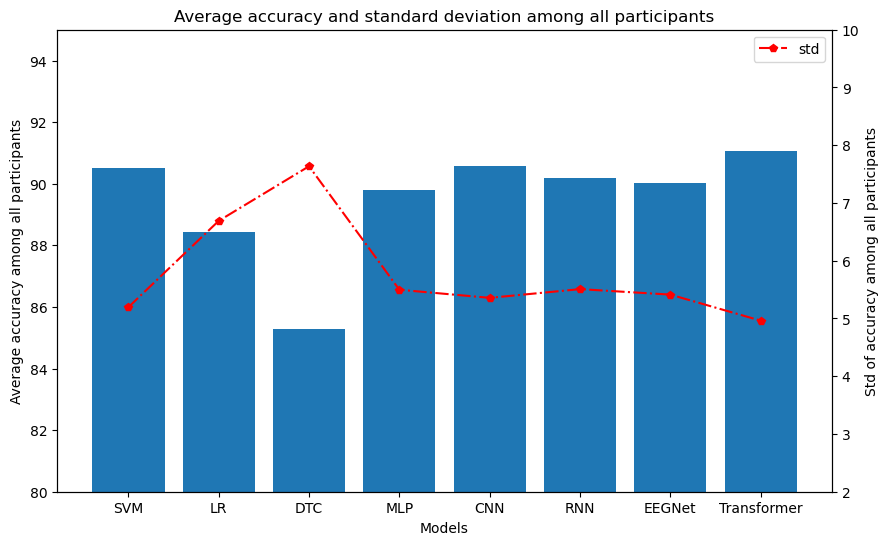

In [72]:
average = [np.mean(acc_tests_SVM), np.mean(acc_tests_LR), np.mean(acc_tests_DTC), 
           np.mean(acc_tests_MLP), np.mean(acc_tests_CNN), np.mean(acc_tests_RNN), np.mean(acc_tests_EEGNet), np.mean(acc_tests_Transformer)]
std = [np.std(acc_tests_SVM), np.std(acc_tests_LR), np.std(acc_tests_DTC), 
       np.std(acc_tests_MLP), np.std(acc_tests_CNN), np.std(acc_tests_RNN), np.std(acc_tests_EEGNet), np.std(acc_tests_Transformer)]
models = ['SVM','LR','DTC','MLP','CNN','RNN','EEGNet','Transformer']
print(average)
print(std)
fig, ax1 = plt.subplots(figsize = (10,6))
ax1.bar(models, average)
ax1.set_xlabel('Models')
ax1.set_ylabel('Average accuracy among all participants')
ax1.set_ybound(80, 95)
ax2 = ax1.twinx()
ax2.plot(models, std, '-.p', color = 'red')
ax2.set_ylabel('Std of accuracy among all participants')
ax2.set_ybound(2.0, 10.0)
plt.title("Average accuracy and standard deviation among all participants")
plt.legend(['std'])
fig.show()

[94.89677794919288, 93.50526959588984, 91.5487422415679, 93.29017803984961, 92.94993233826965, 94.19803521129776, 94.26052280446687, 93.39295103534083]
[2.857359369773091, 3.930629305392489, 4.645927414666463, 4.288903100575746, 5.753003914222919, 3.5043548201148904, 3.286166361004207, 5.366639104693498]


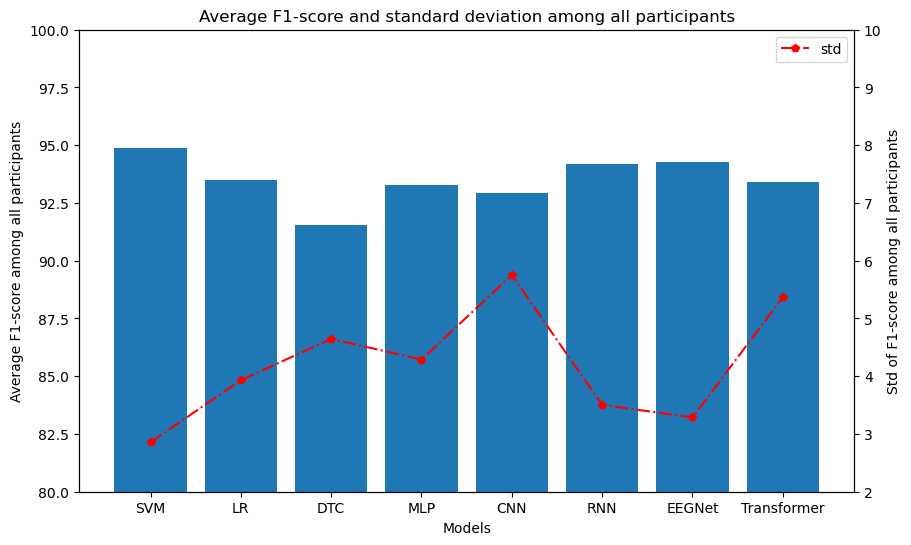

In [73]:
average = [np.mean(f1_tests_SVM), np.mean(f1_tests_LR), np.mean(f1_tests_DTC), 
           np.mean(f1_tests_MLP), np.mean(f1_tests_CNN), np.mean(f1_tests_RNN), np.mean(f1_tests_EEGNet), np.mean(f1_tests_Transformer)]
std = [np.std(f1_tests_SVM), np.std(f1_tests_LR), np.std(f1_tests_DTC), 
       np.std(f1_tests_MLP), np.std(f1_tests_CNN), np.std(f1_tests_RNN), np.std(f1_tests_EEGNet), np.std(f1_tests_Transformer)]
models = ['SVM','LR','DTC','MLP','CNN','RNN','EEGNet','Transformer']
print(average)
print(std)
fig, ax1 = plt.subplots(figsize = (10,6))
ax1.bar(models, average)
ax1.set_xlabel('Models')
ax1.set_ylabel('Average F1-score among all participants')
ax1.set_ybound(80, 100)
ax2 = ax1.twinx()
ax2.plot(models, std, '-.p', color = 'red')
ax2.set_ylabel('Std of F1-score among all participants')
ax2.set_ybound(2.0, 10.0)
plt.title("Average F1-score and standard deviation among all participants")
plt.legend(['std'])
fig.show()